In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import requests
from datetime import datetime, timedelta
from shapely.geometry import Point
from busSim import BusSim
from graph import Graph

In [2]:
from shapely import wkt
df = pd.read_csv("NarrowFactors.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='epsg:4326')

In [3]:
gdf.to_file("NarrowFactors.shp")

In [4]:
from sklearn import preprocessing
# cite from https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
# Get column names first
dfFactors = pd.read_csv("NarrowFactors.csv")
df = dfFactors.iloc[:,2:-1]
names = df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
dfFactors.iloc[:,2:-1] = scaled_df


In [5]:
df_cen = gpd.read_file("zip://plot/background/SCORE.zip")
df_cen.columns

Index(['GEOID10', 'Total Popu', 'Preschool', 'Gradeschoo', 'Teen',
       'Old People', 'White', 'Black or A', 'American I', 'Asian alon',
       'Native Haw', 'Some other', 'Preschoo_1', 'Gradesch_1', 'Teen Perce',
       'Old Peop_1', 'White Perc', 'Black or_1', 'Asian al_1', 'Total Educ',
       'Enrolled a', 'Total Fami', 'under pove', 'Education', 'Poverty Pe',
       'SCORE', 'geometry'],
      dtype='object')

In [8]:
def single_map(name):
    
    # load data from plot data from file
    street = gpd.read_file("./plot/background/street-shp")
    df_cen = gpd.read_file("zip://plot/background/SCORE.zip")
    gdf = gpd.GeoDataFrame(df_cen, geometry=df_cen.geometry)
    
    #menu = pd.read_csv("menu.csv")
    #cato = int(menu[menu.name == name].index.values)
#     key = menu.loc[cato,"key"]
    #fullName = menu.loc[cato,"full_name"]
    
    ax=gdf.plot(column=name, cmap='BuPu',figsize=(8,8),legend=False,alpha=0.35
                 ,legend_kwds={'orientation': "horizontal",
                    'shrink': 0.5,'alpha':0.35,'pad':0.01})
    fig = ax.figure
    #cb_ax = fig.axes[1] 
    #cb_ax.tick_params(labelsize=20)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    ax.set_axis_off()    
    #ax.title.set_text(fullName)
    
    return ax
    


In [10]:
def print_menu():
    menu = pd.read_csv("menu.csv")
    for ix,row in menu.iterrows():
        print(row["name"]+": "+row["full_name"])

In [15]:
def combine_map(catodic,number,pol):
    
    ratioSum = sum(catodic.values())
    
    processDic = {}
    for key,value in catodic.items():
        processDic[key] = value/ratioSum
        
    # load data from plot data from file
    street = gpd.read_file("./plot/background/street-shp")
    df_cen = gpd.read_file("zip://plot/background/SCORE.zip")
    #df_cen["transport"] = -df_cen["transport"]
    
    #menu = pd.read_csv("menu.csv")
    df_cen['utility_map'] = 0
    
    # construct the utility function
    for key in processDic.keys():
        #key = menu.loc[cato,"key"]
        df_cen['utility_map'] += processDic[key]*df_cen[key]

    df_cen = df_cen.sort_values('utility_map',ascending=False)
    gdf = gpd.GeoDataFrame(df_cen, geometry=df_cen.geometry)
    ax=gdf.plot(column='utility_map', cmap='BuPu',figsize=(12,12),legend=False,alpha=1
                 ,legend_kwds={'orientation': "horizontal",
                    'shrink': 0.5,'alpha':0.35,'pad':0.01})
    fig = ax.figure
    #cb_ax = fig.axes[1] 
    #cb_ax.tick_params(labelsize=20)   
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    ax.title.set_text(catodic)
    ax.set_axis_off()
    return ax,df_cen.head(number+pol)
    


In [16]:
def utilityMap(catodic,number,pol):
    #for each in catodic.keys():
    #    single_map(each)
    #plt.subplot(211)
    #fig, (ax0, ax1) = plt.subplots(nrows=2)
    ax, df_cen = combine_map(catodic,number,pol)
    print(len(df_cen))
    x=np.arange(1,len(df_cen)+1)
    SCORE=df_cen['SCORE']
    pdfS=SCORE/np.sum(SCORE)
    cdfS=np.cumsum(pdfS)

    utility = df_cen['utility_map']
    pdfU=utility/np.sum(utility)
    cdfU=np.cumsum(pdfU)
    #ax1 = plt.subplot()
    #plt.plot(x,pdf, marker="o",label="PMF")
    fig, ax1 = plt.subplots(nrows=1)
    figsize = (16,16)
    ax1.plot(x,cdfU,marker="o",label="utility")
    ax1.plot(x,cdfS,marker="o",label="score")
    #plt.xlim(0,len(df_cen))
    #plt.ylim(0,100)
    plt.xlabel("X")
    #plt.ylabel("Probability Values")
    plt.title("CDF for discrete distribution")
    plt.legend()
    #plt.show()
    print(df_cen[['SCORE','utility_map']])

In [13]:
df_cen.columns

Index(['GEOID10', 'Total Popu', 'Preschool', 'Gradeschoo', 'Teen',
       'Old People', 'White', 'Black or A', 'American I', 'Asian alon',
       'Native Haw', 'Some other', 'Preschoo_1', 'Gradesch_1', 'Teen Perce',
       'Old Peop_1', 'White Perc', 'Black or_1', 'Asian al_1', 'Total Educ',
       'Enrolled a', 'Total Fami', 'under pove', 'Education', 'Poverty Pe',
       'SCORE', 'geometry'],
      dtype='object')

10
         SCORE  utility_map
26   22.371240     3.899102
124  20.350882     2.579972
83   -1.608312     2.165949
33   -4.049458     2.154794
6     6.131553     2.012191
76   24.193863     1.695408
140   7.057645     1.655415
180  51.385288     1.564339
127   2.389159     1.448519
123  -1.515792     1.383824


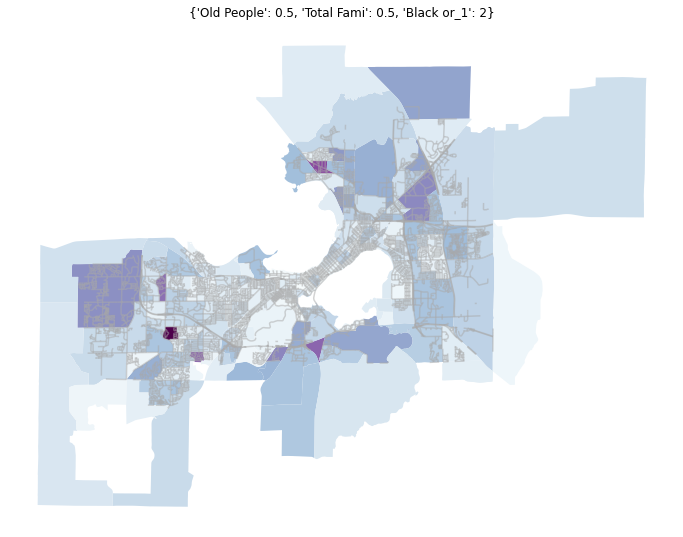

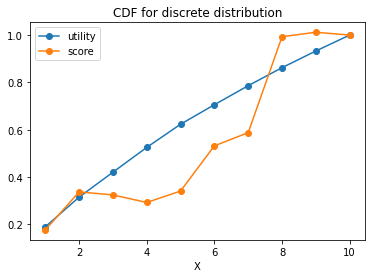

In [17]:
utilityMap({"Old People":0.5,"Total Fami":0.5,'Black or_1':2},5,5)

In [ ]:
utilityMap({"Old People":0.5,'Total Popu':2},5,2)